## Exercise 1.4 Hotdog -- no hotdog
This is the poster hand-in project for the course. Please see the associated PDF for instructions.

In [1]:
import os
import numpy as np
import glob
import PIL.Image as Image
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

We always check that we are running on a GPU

In [2]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU.


We provide you with a class that can load the *hotdog/not hotdog* dataset you should use from /dtu/datasets1/02516/

In [3]:
class Hotdog_NotHotdog(torch.utils.data.Dataset):
    def __init__(self, train, transform, data_path='hotdog_nothotdog'):
        'Initialization'
        data_path = os.path.join(os.getcwd(), data_path)
        self.transform = transform
        data_path = os.path.join(data_path, 'train' if train else 'test')
        image_classes = [os.path.split(d)[1] for d in glob.glob(data_path +'/*') if os.path.isdir(d)]
        image_classes.sort()
        self.name_to_label = {c: id for id, c in enumerate(image_classes)}
        self.image_paths = glob.glob(data_path + '/*/*.jpg')

    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        
        image = Image.open(image_path)
        c = os.path.split(os.path.split(image_path)[0])[1]
        y = self.name_to_label[c]
        X = self.transform(image)
        return X, y

We now want to compute the datasets mean and std. Since neural nets are sensitive to the input scale of the dataset such as the scale of the RGB channels.

This should ensure that each channel (R,G,B) are centered around zero with unit variance and should stabilize our training and make the optimizer more predictable.


We need first to design a transformer which will resize all the images to the IMG_SIZE. We did this to ensure that the input dimensions are uniform and we have picked 224 for the IMG_SIZE as it is very common and people on the internet say it is a good balance between image detail and not getting the GPU on fire.


In [4]:
IMG_SIZE = 224

stats_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE, antialias=True),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
])


Now let's assign a batch size (96 works quite well on this GPU with 8 GB of VRAM -  reduce this number if you get an error about not having enough memory available)
We load the training data and we'll proceed to calculate the mean and std for the whole dataset.

In [5]:

BATCH_SIZE = 96

train_ds_stats = Hotdog_NotHotdog(train=True, transform=stats_transform)
stats_loader = DataLoader(train_ds_stats, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

sum_c = torch.zeros(3, dtype=torch.float64)
sqsum_c = torch.zeros(3, dtype=torch.float64)
count = 0

with torch.no_grad():
    for x, _ in stats_loader:                 # x: [B,3,H,W]
        x = x.to(torch.float64)
        batch_size, channels, height, width = x.shape
        sum_c   += x.sum(dim=[0,2,3])
        sqsum_c += (x * x).sum(dim=[0,2,3])
        count   += batch_size * height * width

mean = (sum_c / count).to(torch.float32)
var  = (sqsum_c / count) - (mean.double() ** 2)
std  = torch.sqrt(var.clamp_min(1e-8)).to(torch.float32)

print("MEAN:", mean.tolist())
print("STD :", std.tolist())


MEAN: [0.5349069237709045, 0.44422993063926697, 0.3525683879852295]
STD : [0.26947343349456787, 0.2638039290904999, 0.2741941511631012]


Let's add the transforms for the training data and for the test data.
We will introduce more randomness in the training data, but we want to keep the test data deterministic, so we will just resize and normalize it.

In [6]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.7, 1.2)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist())
])
test_transform = transforms.Compose([
    transforms.Resize(224, antialias=True),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist())
])


trainset = Hotdog_NotHotdog(train=True, transform=train_transform)
train_loader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
testset = Hotdog_NotHotdog(train=False, transform=test_transform)
test_loader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

Let's look at some images from our data 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6939539..2.3469138].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.985008..2.361216].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.985008..2.361216].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6542089..1.7605253].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5920849..2.0465684].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.985008..1.7176188].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9559026..1.

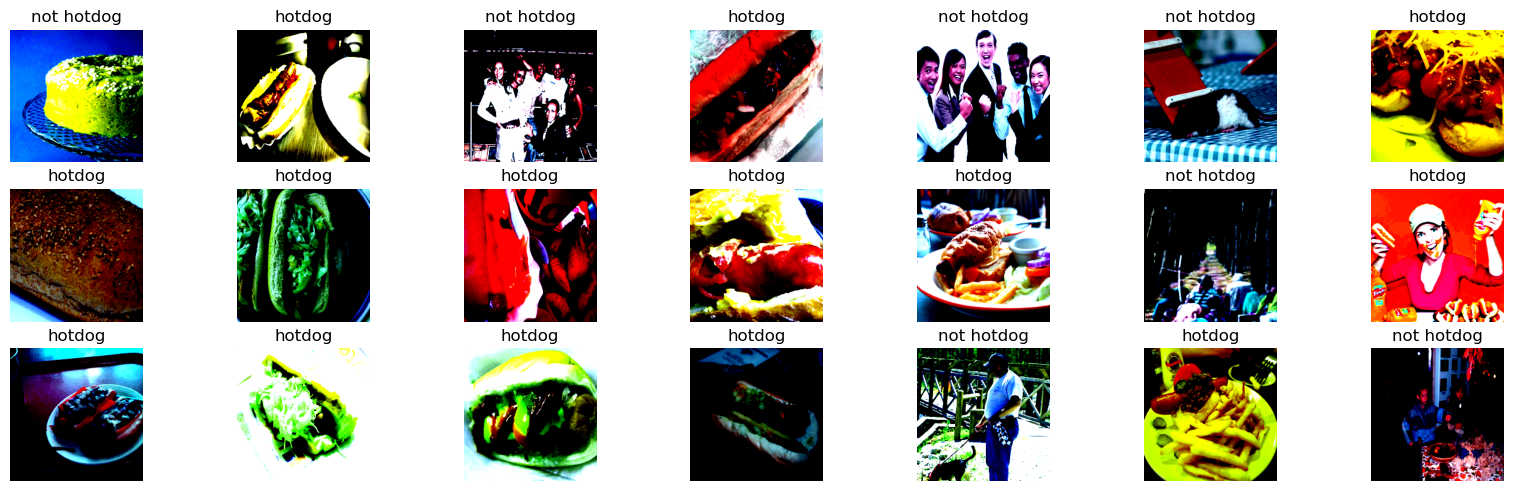

In [7]:
images, labels = next(iter(train_loader))
plt.figure(figsize=(20,10))

for i in range(21):
    plt.subplot(5,7,i+1)
    plt.imshow(np.swapaxes(np.swapaxes(images[i].numpy(), 0, 2), 0, 1))
    plt.title(['hotdog', 'not hotdog'][labels[i].item()])
    plt.axis('off')


plt.show()


Now create a model and train it!


In [8]:
class Network(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),           # ↓ add pooling early: 224→112
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),           # 112→56
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),           # 56→28
        )
        self.block4 = nn.Sequential(
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            # keep spatial size here: 28→28
        )
        self.block5 = nn.Sequential(
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),           # 28→14
        )
        self.block6 = nn.Sequential(
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )
        self.gap = nn.AdaptiveAvgPool2d(1)         # [B,128,1,1]
        self.fc  = nn.Linear(128, num_classes)     # logits, no Softmax

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)          # [B,128,H,W]
        x = self.block6(x)
        x = self.gap(x).flatten(1)  # [B,128]
        x = nn.Dropout(0.3)(x)
        return self.fc(x)           # logits
    
# class BasicBlock(nn.Module):
#     def __init__(self, cin, cout, stride=1):
#         super().__init__()
#         self.down = None
#         if stride != 1 or cin != cout:
#             self.down = nn.Sequential(nn.Conv2d(cin, cout, 1, stride, bias=False),
#                                       nn.BatchNorm2d(cout))
#         self.f = nn.Sequential(
#             nn.Conv2d(cin, cout, 3, stride, 1, bias=False), nn.BatchNorm2d(cout), nn.ReLU(inplace=True),
#             nn.Conv2d(cout, cout, 3, 1, 1, bias=False), nn.BatchNorm2d(cout)
#         )
#         self.relu = nn.ReLU(inplace=True)

#     def forward(self, x):
#         y = self.f(x)
#         if self.down is not None:
#             x = self.down(x)
#         return self.relu(x + y)

# class HotdogResNet(nn.Module):
#     def __init__(self, num_classes=2):
#         super().__init__()
#         self.stem = nn.Sequential(
#             nn.Conv2d(3, 64, 3, 2, 1, bias=False), nn.BatchNorm2d(64), nn.ReLU(inplace=True)
#         )  # 224→112
#         self.stage1 = nn.Sequential(BasicBlock(64, 64), BasicBlock(64, 64))
#         self.stage2 = nn.Sequential(BasicBlock(64, 128, stride=2), BasicBlock(128, 128))   # 112→56
#         self.stage3 = nn.Sequential(BasicBlock(128, 256, stride=2), BasicBlock(256, 256))  # 56→28
#         self.stage4 = nn.Sequential(BasicBlock(256, 512, stride=2), BasicBlock(512, 512)) # 28→14
#         self.head = nn.Sequential(nn.AdaptiveAvgPool2d(1), nn.Flatten(),
#                                   nn.Dropout(0.3), nn.Linear(512, num_classes))
#     def forward(self, x):
#         x = self.stem(x); x = self.stage1(x); x = self.stage2(x); x = self.stage3(x); x = self.stage4(x)
#         return self.head(x)  # logits


In [ ]:
model = Network().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=3e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=2, factor=0.2)


In [ ]:
#We define the training as a function so we can easily re-use it.
def train(model, optimizer, num_epochs=10):
    out_dict = {'train_acc': [],
              'test_acc': [],
              'train_loss': [],
              'test_loss': []}
    
    use_cuda = device.type == "cuda"
    use_amp  = use_cuda  # flip to False if you want to disable AMP
    scaler   = torch.amp.GradScaler(enabled=use_amp)
    criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.05)

    if use_cuda:
        torch.backends.cudnn.benchmark = True
  
    for epoch in tqdm(range(num_epochs), unit='epoch'):
        model.train()
        #For each epoch
        train_correct = 0
        train_loss = []
        for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
            data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)
            #Zero the gradients computed for each weight
            optimizer.zero_grad()
            ctx = torch.amp.autocast(device_type="cuda",dtype=torch.float16) if use_amp else torch.autocast("cpu", enabled=False)
            with ctx:
                logits = model(data)                 # model should return logits, not softmax
                loss   = criterion(logits, target)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            #Forward pass your image through the network
            output = model(data)

            train_loss.append(loss.item())
            #Compute how many were correctly classified
            predicted = output.argmax(1)
            train_correct += (target==predicted).sum().cpu().item()
        #Comput the test accuracy
        test_loss = []
        test_correct = 0
        model.eval()
        with torch.no_grad():
            ctx = torch.amp.autocast(device_type="cuda", dtype=torch.float16) if use_amp else torch.autocast("cpu", enabled=False)
            with ctx:
                for data, target in test_loader:
                    data   = data.to(device, non_blocking=True)
                    target = target.to(device, non_blocking=True)
                    logits = model(data)
                    loss   = criterion(logits, target)
                    test_loss.append(loss.item())
                    test_correct += (logits.argmax(1) == target).sum().item()

        out_dict['train_acc'].append(train_correct / len(train_loader.dataset))
        out_dict['test_acc'].append(test_correct / len(test_loader.dataset))
        out_dict['train_loss'].append(float(np.mean(train_loss)))
        out_dict['test_loss'].append(float(np.mean(test_loss)))
        scheduler.step(out_dict['test_acc'][-1])
        print(f"Loss train: {np.mean(train_loss):.3f}\t test: {np.mean(test_loss):.3f}\t",
              f"Accuracy train: {out_dict['train_acc'][-1]*100:.1f}%\t test: {out_dict['test_acc'][-1]*100:.1f}%")
    return out_dict

In [11]:
out_dict = train(model, optimizer, num_epochs=100)
print(out_dict)
plt.plot(out_dict['train_acc'], label='Train accuracy')
plt.plot(out_dict['test_acc'], label='Test accuracy')
plt.legend()
plt.xlabel('Epoch number')
plt.ylabel('Accuracy')

  0%|          | 0/100 [00:00<?, ?epoch/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Loss train: 0.692	 test: 0.741	 Accuracy train: 68.2%	 test: 67.2%


  0%|          | 0/22 [00:00<?, ?it/s]

Loss train: 0.634	 test: 0.678	 Accuracy train: 67.9%	 test: 64.3%


  0%|          | 0/22 [00:00<?, ?it/s]

Loss train: 0.636	 test: 0.658	 Accuracy train: 68.6%	 test: 69.2%


  0%|          | 0/22 [00:00<?, ?it/s]

Loss train: 0.594	 test: 0.603	 Accuracy train: 71.9%	 test: 71.1%


  0%|          | 0/22 [00:00<?, ?it/s]

Loss train: 0.589	 test: 0.634	 Accuracy train: 74.3%	 test: 72.1%


  0%|          | 0/22 [00:00<?, ?it/s]

Loss train: 0.572	 test: 0.629	 Accuracy train: 75.9%	 test: 72.6%


  0%|          | 0/22 [00:00<?, ?it/s]

Loss train: 0.553	 test: 0.635	 Accuracy train: 76.3%	 test: 73.1%


  0%|          | 0/22 [00:00<?, ?it/s]

Loss train: 0.522	 test: 0.600	 Accuracy train: 78.6%	 test: 70.8%


  0%|          | 0/22 [00:00<?, ?it/s]

Loss train: 0.526	 test: 0.566	 Accuracy train: 78.6%	 test: 72.6%


  0%|          | 0/22 [00:00<?, ?it/s]

KeyboardInterrupt: 